## Getting Started

We will build a 2-agent research workflow which will:

- **Automate Data Acquisition:** Efficiently query, gather, and synthesize up-to-date, relevant web content to establish the initial research context for a given query.

- **Ensure Directional Quality**: Integrate a crucial Human-in-the-Loop (HITL) interrupt mechanism to validate the initial findings and accept directional feedback for necessary refinement before final report generation.

### Setting Up Environment

In [59]:
#Import libraries
import os, uuid
from typing import TypedDict, Annotated, Literal, List
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage
from langgraph.graph import add_messages, StateGraph, END, MessagesState
from langgraph.types import Command, interrupt
from dotenv import load_dotenv
from IPython.display import Image, Markdown, display

In [10]:
load_dotenv(override=True)

True

### Initializing

In [11]:
# 1. Update the LLM initialization for LangGraph with TrueFoundry
llm = ChatOpenAI(
    model=os.getenv("LLM_MODEL_LANGCHAIN"),
    base_url=os.getenv("LLM_GATEWAY_URL"),
    api_key=os.getenv("TFY_API_KEY"),
)

In [12]:
# --- Tools Setup ---
# Tavily Search Tool for web research
tavily_tool = TavilySearch(max_results=5)
tools = [tavily_tool]

### Defining State and Nodes

In [13]:
# --- 2. Shared Graph State ---
class ResearchState(MessagesState):
    """
    Represents the state of our multi-step research process.
    Content is passed between nodes via this state dictionary.
    """
    query: str
    search_context: str
    final_report: str

In [14]:
# --- 3. Agent Functions (Nodes) ---
def researcher_node(state: ResearchState) -> ResearchState:
    """
    NODE 1: Acts as the Researcher Agent.
    1. Uses Tavily to find web context based on the query.
    2. Uses the LLM to summarize and synthesize the raw search results.
    """
    print("--- Researcher Node: Gathering Context ---")
    query = state["query"]
    
    # 1. Tool Call: Tavily Search
    search_context = tavily_tool.invoke({"query": query})
    # Format the search results cleanly
    context_string = "\n\n".join(
        [f"Source: {r['url']}\nTitle: {r['title']}\nSnippet: {r['content'][:300]}..." for r in search_context["results"]]
    )

   # 2. LLM Call: Synthesize/Summarize
    researcher_persona = (
        "You are a Senior Web Researcher. Your goal is to gather the latest and most relevant "
        "information about the user's query and format it as a comprehensive summary. "
        "You are an expert at utilizing the Tavily web search tool to find real-time, accurate, "
        "and cited information on any given topic. Your output must be precise and well-structured."
    )
    
    researcher_instruction = (
        f"""
        TASK: Conduct an 'advanced' web search for the user's query: '{query}'. 
        Focus on recent developments and list all sources used in the final summary.
        
        The final output MUST be a single, well-structured text summary of findings, 
        using ONLY the context provided below. Expected output: A comprehensive, cited summary.

        RESEARCH CONTEXT:
        ---
        {context_string}
        ---
        """
    )
    
    researcher_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=researcher_persona),
        HumanMessage(content=researcher_instruction)
    ])
    
    summary = researcher_prompt | llm
    summary_content = summary.invoke({}).content
    
    # Update the state with the synthesized context
    return {"search_context": summary_content}

In [15]:
def writer_node(state: ResearchState) -> ResearchState:
    """
    NODE 2: Acts as the Writer Agent.
    Takes the synthesis from the Researcher and formats it into a final Markdown report.
    """
    print("--- Writer Node: Generating Final Report ---")
    
    # Get the synthesized context from the previous node's output in the state
    summary = state.get("search_context", "No context found.")
    query = state["query"]

    # LLM Call: Writer
    writer_persona = (
        "You are a Professional Technical Writer. You are a meticulous technical writer "
        "who turns raw research data into polished, production-ready documentation. "
        "Your goal is to write a final, professionally formatted markdown report based on the context provided."
    )

    writer_instruction = (
        f"""
        TASK: Based on the summary provided by the Researcher Agent, write a final report for the query: '{query}'.
        
        The report must be in **Markdown format** with a clear title (using #) and bullet points.
        The final output must be ONLY the Markdown text. Expected output: A Markdown formatted report.

        RESEARCH SUMMARY:
        ---
        {summary}
        ---
        """
    )

    writer_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=writer_persona),
        HumanMessage(content=writer_instruction)
    ])

    report_chain = writer_prompt | llm
    final_report_content = report_chain.invoke({}).content
    
    # Update the state with the final report (this will be the final output of the graph)
    return {"final_report": final_report_content}

### Constructing Graph

In [16]:
# --- 4. Graph Construction ---
# Initialize the StateGraph
workflow = StateGraph(ResearchState)

# Add nodes corresponding to the agents
workflow.add_node("researcher", researcher_node)
workflow.add_node("writer", writer_node)

# Define the sequential edges (Researcher -> Writer -> END)
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.set_finish_point("writer")

# Compile the graph
app = workflow.compile()

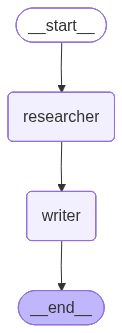

In [9]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

### Example Run

In [10]:
# --- Function to be Wrapped by FastMCP --- this is synchronous here, but we'll make it asynchronous in the final script.
def run_research_analysis(query: str) -> str:
    """
    Executes the compiled LangGraph workflow with a user query.
    This function is what the FastMCP server will call.
    """
    initial_state = {
        "query": query, 
        "search_context": "", 
        "final_report": "", 
        "messages": [HumanMessage(content=query)]
    }
    
    # Invoke the compiled graph
    final_state = app.invoke(initial_state)
    
    # Return the final report content
    return final_state["final_report"]

In [11]:
if __name__ == "__main__":
    # Example Query
    query = "Latest developments in quantum computing hardware in 2025. Keep response limited to 100 words." 
    print(f"--- Starting LangGraph Research Flow for: {query} ---")
    result = run_research_analysis(query)
    # print("\n\n=== FINAL REPORT (LangGraph Output) ===")
    # print(result)

--- Starting LangGraph Research Flow for: Latest developments in quantum computing hardware in 2025. Keep response limited to 100 words. ---
--- Researcher Node: Gathering Context ---
--- Writer Node: Generating Final Report ---


In [12]:
#Final response
display(Markdown(result))

# Quantum Computing Hardware: 2025 Developments

- Fujitsu and RIKEN unveiled a 256‑qubit superconducting system in April 2025—four times larger than their 2023 machine—demonstrating rapid scaling (SpinQuanta).
- Broader assessments report steady chip and architecture improvements, pushing systems closer to practical viability (Communications of the ACM).
- MIT’s 2025 Quantum Index highlights a shift from theory to tangible, commercially promising platforms, indicating movement toward deployment-ready hardware (MIT QIR 2025).
- Net trend: higher qubit counts, maturing architectures, and readiness for early deployment and commercialization across the ecosystem.

## Memory

**We are referring to short-term memory enabled by thread-level persistence here below, and not long-term memory which is across user or applications.**

### In-Memory

In [13]:
from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()

#### Constructing Graph

In [14]:
# Compile the graph with memory
app = workflow.compile(checkpointer = memory)

config = {"configurable": {
    "thread_id": uuid.uuid4()
}}

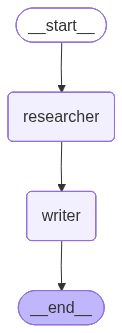

In [15]:
#View graph
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

#### Example Run

In [16]:
# --- Function to be Wrapped by FastMCP --- this is synchronous here, but we'll make it asynchronous in the final script.
def run_research_analysis(query: str) -> str:
    """
    Executes the compiled LangGraph workflow with a user query.
    This function is what the FastMCP server will call.
    """
    initial_state = {
        "query": query, 
        "search_context": "", 
        "final_report": "", 
        "messages": [HumanMessage(content=query)]
    }
    
    # Invoke the compiled graph with thread ID
    final_state = app.invoke(initial_state, config=config)
    
    # Return the final report content
    return final_state["final_report"]

In [17]:
if __name__ == "__main__":
    # Example Query
    query = "Latest developments in quantum computing hardware in 2025. Keep response limited to 100 words." 
    print(f"--- Starting LangGraph Research Flow for: {query} ---")
    result = run_research_analysis(query)
    # print("\n\n=== FINAL REPORT (LangGraph Output) ===")
    # print(result)

--- Starting LangGraph Research Flow for: Latest developments in quantum computing hardware in 2025. Keep response limited to 100 words. ---
--- Researcher Node: Gathering Context ---
--- Writer Node: Generating Final Report ---


In [18]:
#Final response
display(Markdown(result))

# Latest Developments in Quantum Computing Hardware (2025)

- Fujitsu and RIKEN unveiled a 256‑qubit superconducting computer—4× their 2023 system—signaling rapid scaling.
- Rigetti made its 36‑qubit multi‑chip system generally available and outlined a path to a ~100‑qubit machine.
- Iterative chip and architecture improvements are pushing practical viability.
- Momentum is shifting from isolated demos toward usable platforms and clearer performance roadmaps.
- Sources: Spinquanta; Constellation Research; Communications of the ACM.

### Database-Backed Memory

**In production, we should use a checkpointer backed by a database.**

In [19]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3 #in built with Python

In [20]:
#Create a connection string
!mkdir checkpoints
sqlite_conn = sqlite3.connect("checkpoints/checkpoint.sqlite", check_same_thread=False)

# Note: check_same_thread=False is OK as the implementation uses a lock to ensure thread safety.

In [21]:
#Replace memory saver with SqliteSaver - everything else is same
memory = SqliteSaver(sqlite_conn)

**After every single node execution, this checkpointer will append new checkpoints and save the state.**

#### Constructing Graph

In [22]:
# Compile the graph with memory
app = workflow.compile(checkpointer = memory)

config = {"configurable": {
    "thread_id": uuid.uuid4()
}}

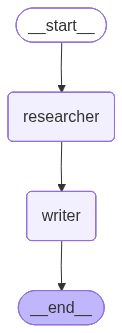

In [23]:
#View graph
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

#### Example Run

In [24]:
# --- Function to be Wrapped by FastMCP --- this is synchronous here, but we'll make it asynchronous in the final script.
def run_research_analysis(query: str) -> str:
    """
    Executes the compiled LangGraph workflow with a user query.
    This function is what the FastMCP server will call.
    """
    initial_state = {
        "query": query, 
        "search_context": "", 
        "final_report": "", 
        "messages": [HumanMessage(content=query)]
    }
    
    # Invoke the compiled graph with thread ID
    final_state = app.invoke(initial_state, config=config)
    
    # Return the final report content
    return final_state["final_report"]

In [25]:
if __name__ == "__main__":
    # Example Query
    query = "Latest developments in quantum computing hardware in 2025. Keep response limited to 100 words." 
    print(f"--- Starting LangGraph Research Flow for: {query} ---")
    result = run_research_analysis(query)
    # print("\n\n=== FINAL REPORT (LangGraph Output) ===")
    # print(result)

--- Starting LangGraph Research Flow for: Latest developments in quantum computing hardware in 2025. Keep response limited to 100 words. ---
--- Researcher Node: Gathering Context ---
--- Writer Node: Generating Final Report ---


In [26]:
#Final response
display(Markdown(result))

# Latest Developments in Quantum Computing Hardware (2025)
- Fujitsu and RIKEN unveiled a 256‑qubit superconducting processor, quadrupling their 2023 machine and signaling a commercial transition.
- Rigetti released a 36‑qubit multi‑chip system for general use and detailed a roadmap toward 100 qubits.
- Industry analyses report accelerated movement from prototypes to commercially promising platforms, with scaling roadmaps solidifying.
- Outlook: 2025 will consolidate real‑world deployments and partnerships, emphasizing practical workloads and integration with classical compute.

**When you delete the SQLite, it causes the memory to not work - "DELETE FROM checkpoints".**

## Human in the Loop

### Introduction

**Human-in-the-loop** workflow integrates human inputs into automated processes, and is especially useful as LLMs can generate inaccurate content or require more information occasionally:

- **Reviewing tool calls**: Reviewing, editing or approving tools calls requested by the LLM before execution 
- **Validating LLM outputs**: Reviewing, editing or approving content generated by LLM
- **Providing context**: For clarification or more details or to support multi-turn conversations

There are 4 key design patterns:

- **Approve or reject**: Depending on the human's approval or rejection, the graph can proceed with the action or take an alternative path.

<img src="images/approve-or-reject.png" width="30%" height = "30%" alt="Approve or reject">


- **Review and edit state**: A human can review and edit the state of the graph. This is useful for correcting mistakes or updating the state with additional information.

<img src="images/edit-graph-state-simple.png" width="40%" height = "40%" alt="Review and edit state">


- **Review tool calls**: A human can review and edit the output from the LLM before proceeding. This is particularly critical in applications where the tool calls requested by the LLM may be sensitive or require human oversight.

<img src="images/tool-call-review.png" width="40%" height = "40%" alt="Review tool calls">


- **Validating human input**: To validate the input provided by the human within the graph itself (rather than on the client side).

Let's take an example:

<img src="images/human-in-the-loop-example.png" width="20%" height = "20%" alt="Example">

### Using interrupt()

**Benefits**:

- Pauses workflow and saves state to pick back up later
- Works in web apps, APIs and other interfaces
- Supports multiple users/sessions concurrently
- Recovers from crashes and handles restarts
- Lets humans take time to respond
- Perfect for human-in-the-loop systems

**There are two ways for using interrupts:**

*1. Interrupt in the compile step*

`graph = graph_builder.compile(checkpointer=checkpointer, interrupt_before = ["tools"])`
    
*2. Interrupt function with command class*

`human_review = interrupt({"question": "Is this correct?", "tool_call": tool_call})`

`if review_action == "continue": return Command(goto = "run_tool")`


**The Command class in LangGraph allows us to create edgeless workflows**.

#### Initializing Database-Backed Memory

In [27]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3 #in built with Python

In [28]:
#Create a connection string
!mkdir checkpoints
sqlite_conn = sqlite3.connect("checkpoints/checkpoint.sqlite", check_same_thread=False)

# Note: check_same_thread=False is OK as the implementation uses a lock to ensure thread safety.

mkdir: checkpoints: File exists


In [29]:
#Replace memory saver with SqliteSaver - everything else is same
memory = SqliteSaver(sqlite_conn)

#### Defining State and Nodes

In [34]:
# --- 2. Shared Graph State ---
class ResearchState(MessagesState):
    """
    Represents the state of our multi-step research process.
    Content is passed between nodes via this state dictionary.
    """
    query: str
    search_context: Annotated[List[str], add_messages] #every time the model returns search results - CHANGED
    human_feedback: Annotated[List[str], add_messages] #every time there's a feedback - CHANGED
    final_report: str

In [51]:
# --- 3. Agent Functions (Nodes) ---
def researcher_node(state: ResearchState) -> ResearchState:
    """
    NODE 1: Acts as the Researcher Agent.
    1. Uses Tavily to find web context based on the query.
    2. Uses the LLM to summarize and synthesize the raw search results.
    """
    print("--- Researcher Node: Gathering Context ---")
    query = state["query"]
    feedback = state["human_feedback"] if "human_feedback" in state else ["No Feedback yet"] ##Adding human feedback
    
    # 1. Tool Call: Tavily Search
    search_context = tavily_tool.invoke({"query": query})
    # Format the search results cleanly
    context_string = "\n\n".join(
        [f"Source: {r['url']}\nTitle: {r['title']}\nSnippet: {r['content'][:300]}..." for r in search_context["results"]]
    )

   # 2. LLM Call: Synthesize/Summarize
    researcher_persona = (
        "You are a Senior Web Researcher. Your goal is to gather the latest and most relevant "
        "information about the user's query and format it as a comprehensive summary. "
        "You are an expert at utilizing the Tavily web search tool to find real-time, accurate, "
        "and cited information on any given topic. Your output must be precise and well-structured."
    )
    
    researcher_instruction = (
        f"""
        TASK: Conduct an 'advanced' web search for the user's query: '{query}'. 

        Human Feedback: {feedback[-1] if feedback else "No feedback yet"}

        Focus on recent developments and list all sources used in the final summary. 
        
        Consider previous human feedback to refine the reponse.
        
        The final output MUST be a single, well-structured text summary of findings, 
        using ONLY the context provided below. Expected output: A comprehensive, cited summary.

        RESEARCH CONTEXT:
        ---
        {context_string}
        ---
        """
    )
    
    researcher_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=researcher_persona),
        HumanMessage(content=researcher_instruction)
    ])
    
    summary = researcher_prompt | llm
    summary_content = summary.invoke({}).content
    
    print(f"[researcher_node] Generated summary:\n{summary_content}\n")

    
    # Update the state with the synthesized context
    return {"search_context": [AIMessage(content=summary_content)]}

In [61]:
def human_node(state: ResearchState) -> ResearchState: 
    """Human Intervention node - loops back to model unless input is done"""

    print("--- Human Node: Awaiting Human Feedback ---")

    search_context = state["search_context"]

    # Interrupt to get user feedback

    user_feedback = interrupt(
        {
            "search_context": search_context, 
            "message": "Provide feedback or type 'done' to finish"
        }
    )

    print(f"[human_node] Received human feedback: {user_feedback}")

    # If user types "done", transition to END node
    if user_feedback.lower() == "done": 
        return Command(update={"human_feedback": state["human_feedback"] + ["Finalised"]}, goto="writer")

    # Otherwise, update feedback and return to model for re-generation
    return Command(update={"human_feedback": state["human_feedback"] + [user_feedback]}, goto="researcher")

In [62]:
def writer_node(state: ResearchState) -> ResearchState:
    """
    NODE 2: Acts as the Writer Agent.
    Takes the synthesis from the Researcher and formats it into a final Markdown report.
    """
    print("--- Writer Node: Generating Final Report ---")
    
    # Get the synthesized context from the previous node's output in the state
    summary = state.get("search_context", "No context found.")
    query = state["query"]

    # LLM Call: Writer
    writer_persona = (
        "You are a Professional Technical Writer. You are a meticulous technical writer "
        "who turns raw research data into polished, production-ready documentation. "
        "Your goal is to write a final, professionally formatted markdown report based on the context provided."
    )

    writer_instruction = (
        f"""
        TASK: Based on the summary provided by the Researcher Agent, write a final report for the query: '{query}'.
        
        The report must be in **Markdown format** with a clear title (using #) and bullet points.
        The final output must be ONLY the Markdown text. Expected output: A Markdown formatted report.

        RESEARCH SUMMARY:
        ---
        {summary}
        ---
        """
    )

    writer_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=writer_persona),
        HumanMessage(content=writer_instruction)
    ])

    report_chain = writer_prompt | llm
    final_report_content = report_chain.invoke({}).content
    
    # Update the state with the final report (this will be the final output of the graph)
    return {"final_report": final_report_content}

#### Constructing Graph

In [63]:
# --- 4. Graph Construction ---
# Initialize the StateGraph
workflow = StateGraph(ResearchState)

# Add nodes corresponding to the agents
workflow.add_node("researcher", researcher_node)
workflow.add_node("human", human_node)
workflow.add_node("writer", writer_node)

# Define the sequential edges (Researcher -> Writer -> END)
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "human")
workflow.set_finish_point("writer")

# Compile the graph with database-backed memory
app = workflow.compile(checkpointer = memory)

config = {"configurable": {
    "thread_id": uuid.uuid4()
}}

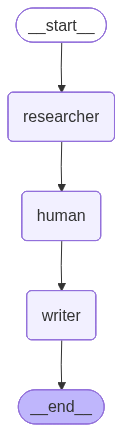

In [64]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

#### Example Run

**Common Streaming Modes**:

- Stream mode to values means that after execution of every node, an event will be emitted showing us the entire state at that point --> **.stream(stream_mode="values")**
- Stream mode to updates gives the new item that has been added to the list, and which node did the change --> **.stream(stream_mode="updates")**
- Stream the events as they happen inside the node, not at the end of the node! And use latest version - v2.  --> **.astream_events()**

In [65]:
# --- Function to be Wrapped by FastMCP --- this is synchronous here, but we'll make it asynchronous in the final script.
def run_research_analysis(query: str) -> str:
    """
    Executes the compiled LangGraph workflow with a user query.
    This function is what the FastMCP server will call.
    """
    initial_state = {
        "query": query, 
        "search_context": [],
        "human_feedback": [],
        "final_report": "", 
        "messages": [HumanMessage(content=query)]
    }

    # Stream the compiled graph with interrupt()
    for chunk in app.stream(initial_state, config=config):
        for node_id, value in chunk.items():
            #  If we reach an interrupt, continuously ask for human feedback
    
            if(node_id == "__interrupt__"):
                while True: 
                    user_feedback = input("Provide feedback (or type 'done' when finished): ")
    
                    # Resume the graph execution with the user's feedback
                    app.invoke(Command(resume=user_feedback), config=config)
    
                    # Exit loop if user says done
                    if user_feedback.lower() == "done":
                        break
    
    # The graph execution is complete. Retrieve the final state from the checkpointer.
    final_state = app.get_state(config).values
    
    # Return the final report content
    return final_state["final_report"]

In [66]:
if __name__ == "__main__":
    # Example Query
    query = "Latest developments in quantum computing hardware in 2025. Keep response limited to 100 words." 
    print(f"--- Starting LangGraph Research Flow for: {query} ---")
    result = run_research_analysis(query)
    # print("\n\n=== FINAL REPORT (LangGraph Output) ===")
    # print(result)

--- Starting LangGraph Research Flow for: Latest developments in quantum computing hardware in 2025. Keep response limited to 100 words. ---
--- Researcher Node: Gathering Context ---
[researcher_node] Generated summary:
Quantum hardware in 2025 is scaling and maturing. Fujitsu and RIKEN unveiled a 256‑qubit superconducting system—4× their 2023 device—signaling rapid qubit growth. Rigetti made its 36‑qubit multi‑chip machine generally available and outlined a path to a 100‑qubit system, underscoring modular architectures. Analysts expect continued chip and architecture refinements to push viability and commercialization momentum across 2025. Sources: https://www.spinquanta.com/news-detail/quantum-computing-industry-trends-2025-breakthrough-milestones-commercial-transition https://www.constellationr.com/blog-news/insights/2025-year-quantum-computing https://mags.acm.org/communications/august_2025/MobilePagedArticle.action?articleId=2073733 https://thequantuminsider.com/2024/12/31/2025-e

Provide feedback (or type 'done' when finished):  Something on NVQAC is also needed.



 [human_node] awaiting human feedback...
[human_node] Received human feedback: Something on NVQAC is also needed.
--- Researcher Node: Gathering Context ---
--- Writer Node: Generating Final Report ---
[researcher_node] Generated summary:
Quantum hardware in 2025 is accelerating: Fujitsu/RIKEN debuted a 256‑qubit superconducting system (4× 2023), with larger, higher‑fidelity roadmaps. Rigetti’s 36‑qubit multi‑chip machine is GA; a ~100‑qubit, ~99% target follows. CACM underscores continual chip/architecture gains toward viability. Algorithm–hardware co‑design advances via adaptive VQE “chunking,” easing circuit depth. Predictions foresee maturing hardware enabling real applications. Note: NVQAC-related efforts are relevant to this co‑design/hardware maturation, but details aren’t in the provided sources. Sources: SpinQuanta; Constellation Research; Communications of the ACM; Medium; The Quantum Insider.


 [human_node] awaiting human feedback...


Provide feedback (or type 'done' when finished):  done



 [human_node] awaiting human feedback...
[human_node] Received human feedback: done
--- Writer Node: Generating Final Report ---


In [68]:
#Final response
display(Markdown(result))

# Latest Developments in Quantum Computing Hardware (2025)

- Scaling: Fujitsu and RIKEN unveiled a 256‑qubit superconducting processor—4× their 2023 device—signaling rapid growth.
- Modular chips: Rigetti’s 36‑qubit multi‑chip system is generally available; roadmap targets ~100 qubits and ~99% fidelities.
- Architecture refinement: Continued advances in interconnects, cryo‑electronics, packaging, and calibration improve stability and yield (CACM).
- Co‑design: Algorithm–hardware co‑design (e.g., adaptive VQE “chunking”) reduces circuit depth and hardware demands.
- Commercialization: Analysts forecast momentum from maturing hardware into practical piloting and early value across 2025.